In [30]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from functools import reduce
from nltk.util import ngrams
from nltk.corpus import words
import matplotlib.pyplot as plt
import pandas as pd
import math
import nltk
import os
import re

### Initializing the sparkcontext

In [3]:
MAX_MEMORY = "10g"
# sc.stop()
spark = SparkSession.builder.appName("Foo").config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY).getOrCreate()

# Part A:

## 1: Loading in the data

In [4]:
df = spark.read.json("text/*")
df.count()

711032

# TEMP!!!! REMOVE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [5]:
df = spark.read.json("text/AB/*", multiLine=True)
df.count()

100

In [6]:
df.first()

Row(id='238077', text='عبدالحمید ملک\u200cالکلامی\n\nعبدالحمید ملک الکلامی معروف به امیرالکتاب (۱۲۶۲–۱۳۲۸ ه\u200d. ش) یکی از خوشنویسان ایران است. وی به نستعلیق، ثلث، نسخ، شکسته\u200cنستعلیق مسلط بود. او خطاطی مبتکر و فرزند میرزا عبدالمجید مجدی سقزی معروف بهمیرزا مجدالدین ملک الکلام کردستانی است. او در سال ۱۲۶۲ه\u200d. ش در سنندج کردستان چشم به جهان گشود و در مهرماه ۱۳۲۸ه\u200d. ش در سن شصت و چهار سالگی درگذشته و در تهران به خاک سپرده شده\u200cاست.\n\nاو در انواع خطوط نسخ، ثلث، رقاع، نستعلیق و شکسته از استادان مسلم بود. این هنر مند خطوط طغرایی را بسیار زیبا می\u200cنوشت و در ساختن مرکب و آهار و مهره کردن کاغذ استاد بود. افزون بر خط، او در نقاشی آب\u200cرنگ نیز دست داشت. عبدالحمید ملک الکلامی به نقاری و حکاکی مسلط بود و بعضی سرسکه\u200cهای ضرابخانه دولتی آن زمان را او تهیه کرده\u200cاست.\n\nقریحه شاعری را از پدر به ارث برده بود و «شرقی» تخلص می\u200cکرد. کتیبه\u200cهای آرامگاه حافظ در شیراز و کتیبه\u200cهای حجاری شده موزه ایران باستان به خط ثلث اوست.\n', title='عبدالحمید ملک\u200cالکلامی

### Converting to RDD & removing xml tags

###### index 0 => ID
###### index 1 => URL
###### index 2 => Title
###### index 3 => Text

In [7]:
def textCleanUp(text):
    clean1 = re.compile(r'[\n\r\t]')
    clean2 = re.compile('<.*?>')
    clean3 = re.compile(' +')
    newT = re.sub(clean3,' ', re.sub(clean2, '',re.sub(clean1, ' ', text))).strip()
    return newT
    

def getRDD(row):
    return (row['id'], row['url'], textCleanUp(row['title']), textCleanUp(row['text']))


textual = df.rdd.map(lambda row: getRDD(row))
textual.first()

('238077',
 'https://fa.wikipedia.org/wiki?curid=238077',
 'عبدالحمید ملک\u200cالکلامی',
 'عبدالحمید ملک\u200cالکلامی عبدالحمید ملک الکلامی معروف به امیرالکتاب (۱۲۶۲–۱۳۲۸ ه\u200d. ش) یکی از خوشنویسان ایران است. وی به نستعلیق، ثلث، نسخ، شکسته\u200cنستعلیق مسلط بود. او خطاطی مبتکر و فرزند میرزا عبدالمجید مجدی سقزی معروف بهمیرزا مجدالدین ملک الکلام کردستانی است. او در سال ۱۲۶۲ه\u200d. ش در سنندج کردستان چشم به جهان گشود و در مهرماه ۱۳۲۸ه\u200d. ش در سن شصت و چهار سالگی درگذشته و در تهران به خاک سپرده شده\u200cاست. او در انواع خطوط نسخ، ثلث، رقاع، نستعلیق و شکسته از استادان مسلم بود. این هنر مند خطوط طغرایی را بسیار زیبا می\u200cنوشت و در ساختن مرکب و آهار و مهره کردن کاغذ استاد بود. افزون بر خط، او در نقاشی آب\u200cرنگ نیز دست داشت. عبدالحمید ملک الکلامی به نقاری و حکاکی مسلط بود و بعضی سرسکه\u200cهای ضرابخانه دولتی آن زمان را او تهیه کرده\u200cاست. قریحه شاعری را از پدر به ارث برده بود و «شرقی» تخلص می\u200cکرد. کتیبه\u200cهای آرامگاه حافظ در شیراز و کتیبه\u200cهای حجاری شده موزه ایران ب

## 2: One-hundred most frequent words
## 3: Least frequent words

### Tokenizing into words & counting words

In [8]:
words = textual.flatMap(lambda row: nltk.word_tokenize(str(row[2])+' '+str(row[3])))

to_count = words.map(lambda word: (word,1))
counted = to_count.reduceByKey(lambda a,b: a+b)
counted.first()

('ملک\u200cالکلامی', 2)

In [9]:
countedDF = counted.toDF(['word','count'])
countedDF = countedDF.sort('count',ascending=False)
countedDF.count()

20326

## one hundred most frequent

In [10]:
mostFreq = countedDF.head(100)
mostFreq = [row.word for row in mostFreq]
len(mostFreq)

100

## least frequent

In [11]:
leastFreq = countedDF.filter('count < 20')
leastFreq = leastFreq.select('word').rdd.map(lambda row: row[0]).collect()
len(leastFreq)

19336

## 4: Remove all least frequent and one hundred most frequent words

In [12]:
to_remove = mostFreq + leastFreq
def remove_words(text,removee):
    words = nltk.word_tokenize(text)
    result = [word for word in words if word not in removee]
    return ' '.join(result)

newText = textual.map(lambda row: (row[0],row[1],remove_words(row[2],to_remove),remove_words(row[3],to_remove)))
# newText.first()

# Part B:

## 1: Number of unique words

In [40]:
counted.count() - len(to_remove)

890

## 2: One-hundred most frequent trigrams

In [41]:
trigrams = newText.flatMap(
    lambda row: list(ngrams(nltk.word_tokenize(row[2]),3))+list(ngrams(nltk.word_tokenize(row[3]),3)))
to_count = trigrams.map(lambda row: (row,1))
counted = to_count.reduceByKey(lambda a,b: a+b)
counted.first()

(('سالگی', 'تهران', 'خاک'), 1)

In [42]:
countedDF = counted.toDF(['trigram','count'])
countedDF = countedDF.sort('count',ascending=False)
countedDF

DataFrame[trigram: struct<_1:string,_2:string,_3:string>, count: bigint]

In [43]:
mostFreq = countedDF.head(100)
mostFreq = [(row.trigram._1,row.trigram._2,row.trigram._3) for row in mostFreq]
len(mostFreq)

100

## 3: One-hundred most frequent English words

In [52]:
eng_vocab = set(w.lower() for w in nltk.corpus.words.words())
def extract_eng_words(word_list,vocab):
    result = [word for word in word_list if word.lower() in vocab]
    return result

eng_words = newText.flatMap(
    lambda row: 
    extract_eng_words(nltk.word_tokenize(row[2]),eng_vocab)+extract_eng_words(nltk.word_tokenize(row[2]),eng_vocab))
to_count = eng_words.map(lambda row: (row,1))
counted = to_count.reduceByKey(lambda a,b: a+b)
counted_list = counted.collect()
counted_list

[]

In [53]:
if len(counted_list) > 0 :
    countedDF = counted.toDF(['word','count'])
    countedDF = countedDF.sort('count',ascending=False)
    countedDF.count()

In [54]:
if len(counted_list) > 0 :
    mostFreq = countedDF.head(100)
    mostFreq = [row.word for row in mostFreq]
    mostFreq

## 4: Longest text URL

In [10]:
text_length = newText.map(lambda row: ((row[0],row[1],row[2],row[3]),len(row[3])))
text_length.max(lambda row: row[1])[0][1]

'https://fa.wikipedia.org/wiki?curid=140680'

# 5: My name is not that common

In [11]:
my_name = newText.filter(lambda row : 
                         (('mahtab' in (row[2]+' '+row[3]).lower()) or ('مهتاب' in row[2]+' '+row[3])))
my_name_list = my_name.collect()
len(my_name_list)

0

# 6: Histogram of text length

### In order to choose the best bin sizes, we need to work with the whole data.
### Assuming the distribtion of the length of text to be normal, bin width needs to be minimal around the mean value of the data and scattered data can be omitted.

In [18]:
length_list = text_length.collect()

In [21]:
length_x = [l[1] for l in length_list]
len(length_x)

100

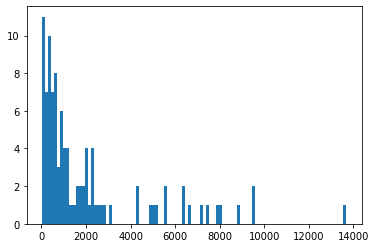

In [26]:
plt.hist(length_x, bins = 100)
plt.show()

# Part C:

## 1: Creating TF-IDF dictionary

In [82]:
text = newText.map(lambda row: [row[0],row[1],row[2],str(row[2])+' '+str(row[3])])
countDocs = text.count()

def insertTFIDF(row):
    res = []
    words =  nltk.word_tokenize(row[-1])
    return [[(row[0],row[1],row[2],len(words),word),1] for word in words]

tfidf = newText.flatMap(insertTFIDF)
tfidf = tfidf.reduceByKey(lambda a,b: a+b)

tfidf = tfidf.map(lambda row: [(row[0][0],row[0][1],row[0][2]),
                               row[0][-1],float(row[1])/float(row[0][-2]),row[0][-2]])

idfCompute = tfidf.map(lambda row: (row[1],1))
idfCompute = idfCompute.reduceByKey(lambda a,b: float(a+b))
# tfidf.first()


In [71]:
idfOrder = list(set([i[0] for i in idf]))

idfDict = dict(idf)
idfDict['جهان']

3.4473131088235682

In [76]:
tfidfComputed = tfidf.map(lambda row : [(row[0][0],row[0][1],row[0][2],row[1]),row[2]*idfDict[row[1]]])
tfidfComputed.first()

[('238077', 'https://fa.wikipedia.org/wiki?curid=238077', '', 'جهان'),
 0.1566960504010713]

In [81]:
def makeFinal(row):
    result = [row]
    for word in idfOrder:
        result.append([(row[0][0],row[0][1],row[0][2],word),-1])
    return result



finalTFIDF = tfidfComputed.flatMap(makeFinal)
finalTFIDF = finalTFIDF.reduceByKey(lambda a,b : max(a,b))
finalTFIDF.count()

17305

45